In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path = '/content/drive/MyDrive/Dataset 2B.zip'

In [4]:
zip_path = '/content/drive/MyDrive/Dataset 2B.zip'
extract_path = '/content/Dataset_2B'

In [5]:
# Ekstrak file ZIP
import zipfile

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [6]:
import os
print(os.listdir(extract_path))

['validation', 'test', 'train', 'val']


In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from collections import Counter

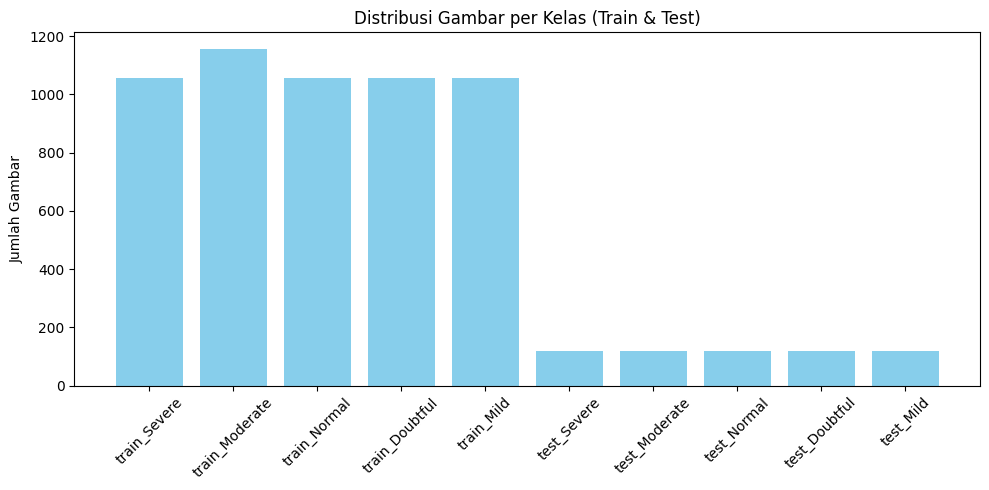

In [8]:
from collections import Counter

def count_images_in_classes(base_dir):
    class_counts = {}
    for subset in ['train', 'test']:
        subset_path = os.path.join(base_dir, subset)
        for class_name in os.listdir(subset_path):
            class_dir = os.path.join(subset_path, class_name)
            num_images = len(os.listdir(class_dir))
            class_counts[f'{subset}_{class_name}'] = num_images
    return class_counts

counts = count_images_in_classes(extract_path)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(counts.keys(), counts.values(), color='skyblue')
plt.title('Distribusi Gambar per Kelas (Train & Test)')
plt.xticks(rotation=45)
plt.ylabel('Jumlah Gambar')
plt.tight_layout()
plt.show()

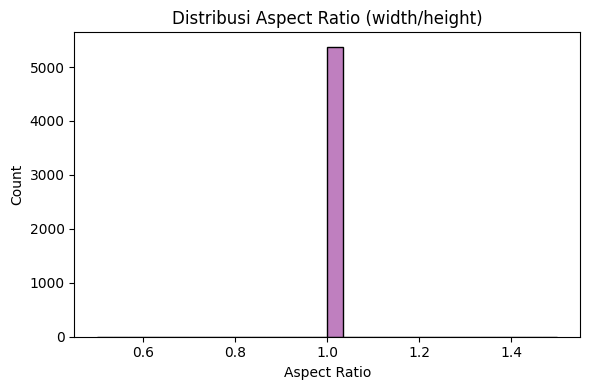

In [9]:
from PIL import Image
import pandas as pd

dimensions = []
aspect_ratios = []
errors = []

# Hanya memproses data train
train_path = os.path.join(extract_path, 'train')

# Loop untuk semua kelas di folder train
for class_name in os.listdir(train_path):
    class_dir = os.path.join(train_path, class_name)
    for filename in os.listdir(class_dir):
        file_path = os.path.join(class_dir, filename)
        try:
            with Image.open(file_path) as img:
                w, h = img.size
                dimensions.append((w, h))
                aspect_ratios.append(w / h)
        except Exception as e:
            # Menyimpan error dan file yang gagal dibuka
            errors.append({'file': file_path, 'error': str(e)})

# Sekarang histogram aspect ratio hanya sekali dibuat
plt.figure(figsize=(6, 4))
sns.histplot(aspect_ratios, bins=30, color='purple', kde=True)
plt.title("Distribusi Aspect Ratio (width/height)")
plt.xlabel("Aspect Ratio")
plt.tight_layout()
plt.show()

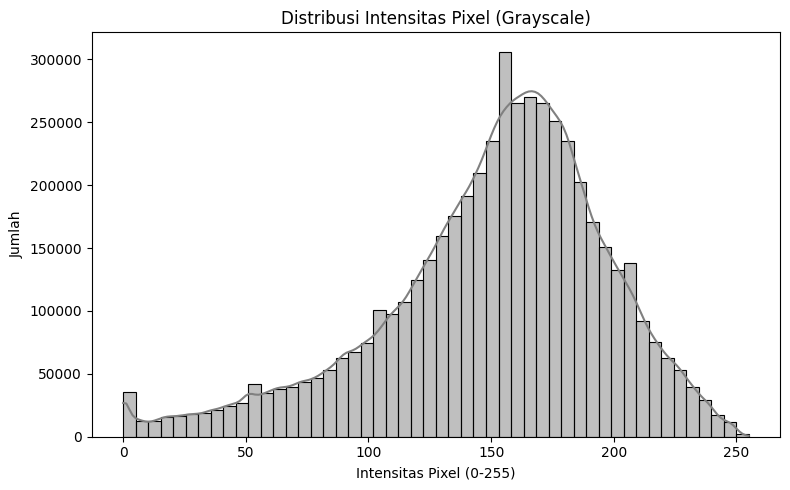

In [10]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

pixel_values = []

train_path = os.path.join(extract_path, 'train')

# Ambil sebagian gambar dari tiap kelas untuk dihitung histogramnya
for class_name in os.listdir(train_path):
    class_dir = os.path.join(train_path, class_name)
    for filename in os.listdir(class_dir)[:20]:  # ambil sebagian saja biar ringan
        file_path = os.path.join(class_dir, filename)
        try:
            with Image.open(file_path) as img:
                # Convert ke grayscale dulu
                gray_img = img.convert('L')
                # Flatten array jadi 1D
                pixels = np.array(gray_img).flatten()
                pixel_values.extend(pixels)
        except Exception as e:
            continue

# Plot histogram intensitas pixel
plt.figure(figsize=(8, 5))
sns.histplot(pixel_values, bins=50, color='gray', kde=True)
plt.title('Distribusi Intensitas Pixel (Grayscale)')
plt.xlabel('Intensitas Pixel (0-255)')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

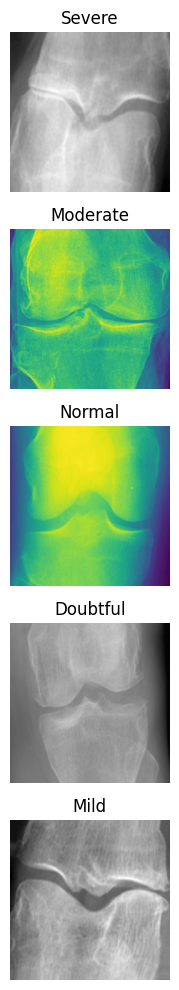

In [11]:
import matplotlib.pyplot as plt
import os
from PIL import Image

train_path = os.path.join(extract_path, 'train')

# Menampilkan 1 gambar acak dari setiap kelas
plt.figure(figsize=(15, 10))
for idx, class_name in enumerate(os.listdir(train_path)):
    class_dir = os.path.join(train_path, class_name)
    image_files = os.listdir(class_dir)  # Ambil semua gambar dalam kelas
    file_path = os.path.join(class_dir, image_files[0])  # Ambil gambar pertama
    try:
        with Image.open(file_path) as img:
            plt.subplot(len(os.listdir(train_path)), 1, idx + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"{class_name}")
    except Exception as e:
        continue

plt.tight_layout()
plt.show()

# **PREPROCESSING DATA**

In [12]:
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

# Tentukan direktori dataset
base_dir = '/content/Dataset_2B'  # Ganti dengan path dataset Anda
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Membuat folder validasi jika belum ada
val_dir = os.path.join(base_dir, 'val')
os.makedirs(val_dir, exist_ok=True)

# Membagi data train menjadi train dan validation
for cls in os.listdir(train_dir):
    cls_dir = os.path.join(train_dir, cls)
    images = os.listdir(cls_dir)
    train_imgs, val_imgs = train_test_split(images, test_size=0.15, random_state=42)

    val_cls_dir = os.path.join(val_dir, cls)
    os.makedirs(val_cls_dir, exist_ok=True)

    for img in val_imgs:
        shutil.move(os.path.join(cls_dir, img), os.path.join(val_cls_dir, img))

# Tentukan jumlah kelas
num_classes = len(os.listdir(train_dir))

# Preprocessing dan Augmentasi untuk data train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Untuk validasi hanya normalisasi (tanpa augmentasi)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Membaca data gambar menggunakan flow_from_directory
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Folder data latih
    target_size=(224, 224),  # Ukuran gambar setelah diresize
    batch_size=32,
    class_mode='categorical'  # Klasifikasi multi-kelas
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,  # Folder data validasi
    target_size=(224, 224),  # Ukuran gambar setelah diresize
    batch_size=32,
    class_mode='categorical'  # Klasifikasi multi-kelas
)

test_generator = validation_datagen.flow_from_directory(
    test_dir,  # Folder data test
    target_size=(224, 224),  # Ukuran gambar setelah diresize
    batch_size=32,
    class_mode='categorical',  # untuk multiclass classification
)

Found 4565 images belonging to 5 classes.
Found 1598 images belonging to 5 classes.
Found 586 images belonging to 5 classes.


# **CNN MODEL**

In [13]:
# Model AlexNet
def create_alexnet(input_shape=(224, 224, 3), num_classes=num_classes):
    model = models.Sequential()

    # Conv Layers
    model.add(layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    model.add(layers.Conv2D(256, (5, 5), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Flatten sebelum Dense!
    model.add(layers.Flatten())

    # Fully Connected Layers
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(1000, activation='relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Buat dan compile model
model = create_alexnet(input_shape=(224, 224, 3), num_classes=num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Ringkasan model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    26,218,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │     4,097,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         5,005 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,849,013 (193.97 MB)

 Trainable params: 50,849,013 (193.97 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator)
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 500ms/step - accuracy: 0.2035 - loss: 2.0207 - val_accuracy: 0.2140 - val_loss: 1.6104
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 64s 449ms/step - accuracy: 0.2209 - loss: 1.6093 - val_accuracy: 0.2140 - val_loss: 1.6093
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 81s 447ms/step - accuracy: 0.2118 - loss: 1.6089 - val_accuracy: 0.2140 - val_loss: 1.6089
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 63s 438ms/step - accuracy: 0.2160 - loss: 1.6090 - val_accuracy: 0.2140 - val_loss: 1.6090
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 64s 445ms/step - accuracy: 0.2048 - loss: 1.6100 - val_accuracy: 0.2140 - val_loss: 1.6090
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 81s 441ms/step - accuracy: 0.2080 - loss: 1.6101 - val_accuracy: 0.2140 - val_loss: 1.6089
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 452ms/step - accuracy: 0.2135 - loss: 1.6093 - val_accuracy: 0.2140 - val_loss: 1.6089
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 81s 446ms/step - accuracy: 0.2100 - loss: 1

# **MODIFIKASI**

In [15]:
pip install tensorflow

In [16]:
pip install tensorflow-addons

In [17]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.efficientnet import preprocess_input

# Tentukan direktori dataset
base_dir = '/content/Dataset_2B'  # Ganti dengan path dataset Anda
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Membuat folder validasi jika belum ada
val_dir = os.path.join(base_dir, 'val')
os.makedirs(val_dir, exist_ok=True)

# Membagi data train menjadi train dan validation
for cls in os.listdir(train_dir):
    cls_dir = os.path.join(train_dir, cls)
    images = os.listdir(cls_dir)
    train_imgs, val_imgs = train_test_split(images, test_size=0.15, random_state=42)

    val_cls_dir = os.path.join(val_dir, cls)
    os.makedirs(val_cls_dir, exist_ok=True)

    for img in val_imgs:
        shutil.move(os.path.join(cls_dir, img), os.path.join(val_cls_dir, img))

# Tentukan jumlah kelas
num_classes = len(os.listdir(train_dir))

# Preprocessing dan Augmentasi untuk data train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input  # Preprocessing EfficientNet
)

# Untuk validasi hanya normalisasi (tanpa augmentasi)
validation_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)

# Membaca data gambar menggunakan flow_from_directory
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Folder data latih
    target_size=(224, 224),  # Ukuran gambar setelah diresize
    batch_size=32,
    class_mode='categorical'  # Klasifikasi multi-kelas
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,  # Folder data validasi
    target_size=(224, 224),  # Ukuran gambar setelah diresize
    batch_size=32,
    class_mode='categorical'  # Klasifikasi multi-kelas
)

test_generator = validation_datagen.flow_from_directory(
    test_dir,  # Folder data test
    target_size=(224, 224),  # Ukuran gambar setelah diresize
    batch_size=32,
    class_mode='categorical',  # untuk multiclass classification
)

Found 3877 images belonging to 5 classes.
Found 2166 images belonging to 5 classes.
Found 586 images belonging to 5 classes.


In [18]:
# **Mengganti Arsitektur AlexNet dengan EfficientNetB0**
def create_efficientnet(input_shape=(224, 224, 3), num_classes=num_classes):
    # Memuat model EfficientNetB0 yang sudah terlatih dan tanpa fully connected layers terakhir
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze layer dari pre-trained model
    base_model.trainable = False

    model = models.Sequential()

    # Menambahkan layer convolutional dari EfficientNetB0
    model.add(base_model)

    # Batch Normalization setelah base model
    model.add(layers.BatchNormalization())

    # Global Average Pooling untuk mengurangi ukuran tensor
    model.add(layers.GlobalAveragePooling2D())

    # Fully Connected Layers
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout untuk mencegah overfitting

    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(num_classes, activation='softmax'))  # Klasifikasi multi-kelas

    return model

# Buat dan compile model
model = create_efficientnet(input_shape=(224, 224, 3), num_classes=num_classes)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Ringkasan model
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 1280)     │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,893,800 (22.48 MB)

 Trainable params: 1,841,669 (7.03 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [19]:
# **Training model dengan Augmentasi dan validasi**
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator)
)

Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 117s 661ms/step - accuracy: 0.1883 - loss: 1.6232 - val_accuracy: 0.1967 - val_loss: 1.6102
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 105s 461ms/step - accuracy: 0.2051 - loss: 1.6243 - val_accuracy: 0.2133 - val_loss: 1.6092
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 58s 476ms/step - accuracy: 0.1971 - loss: 1.6240 - val_accuracy: 0.1967 - val_loss: 1.6095
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 57s 470ms/step - accuracy: 0.1869 - loss: 1.6259 - val_accuracy: 0.1967 - val_loss: 1.6095
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 81s 465ms/step - accuracy: 0.1937 - loss: 1.6220 - val_accuracy: 0.2133 - val_loss: 1.6093
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 58s 478ms/step - accuracy: 0.2032 - loss: 1.6211 - val_accuracy: 0.2133 - val_loss: 1.6093
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 79s 456ms/step - accuracy: 0.2010 - loss: 1.6233 - val_accuracy: 0.1967 - val_loss: 1.6095
Epoch 8/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 57s 466ms/step - accuracy: 0.1945 - loss:

In [20]:

# Evaluasi model pada data test
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test Accuracy: {test_accuracy:.2f}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 319ms/step - accuracy: 0.1634 - loss: 1.6102
Test Accuracy: 0.20


In [21]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Get true labels
true_labels = test_generator.classes

# Get predictions
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate metrics
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 376ms/step
Precision: 0.0399
Recall: 0.2000
F1 Score: 0.0666


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
